In [66]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

import correlation
import arima
import ewma

plt.rcParams["figure.dpi"] = 200
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [67]:
LINE = 'MM15'
# BB16      22282
# BB61      21179
# BB62      22005
# MM15      23108
# TT7       15122

In [68]:
file = f'NYU-METS/Multivariate_Dataset/dataset/{LINE}/{LINE}.txt'

df = pd.read_csv(file, names=['bandwidth', 'LTE-neighbors', 'RSSI', 'RSRQ', 'ENodeB-change', 'time-advance', 'speed', 'band'])
#bandwidth throughput, LTE-neighbors, RSSI, RSRQ, Echng (whether ENodeB has changed from previous second), 
#TA (time advance needed to reach the ENodeB), Speed (moving speed of device), Band (frequency band of signal)

# Add time for Informer model to use as date
df['date'] = pd.date_range(start='1/1/2023', periods=len(df), freq='s')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23108 entries, 0 to 23107
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   bandwidth      23108 non-null  float64       
 1   LTE-neighbors  23108 non-null  float64       
 2   RSSI           23108 non-null  float64       
 3   RSRQ           23108 non-null  float64       
 4   ENodeB-change  23108 non-null  float64       
 5   time-advance   23108 non-null  float64       
 6   speed          23108 non-null  float64       
 7   band           23108 non-null  float64       
 8   date           23108 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(8)
memory usage: 1.6 MB


In [69]:
df.describe()

,bandwidth,LTE-neighbors,RSSI,RSRQ,ENodeB-change,time-advance,speed,band,date
count,23108.000000,23108.000000,23108.000000,23108.000000,23108.000000,23108.000000,23108.000000,23108.000000,23108
mean,20.633769,7.567725,0.023758,76.641596,13.808768,0.691708,2.521656,2015.163580,2023-01-01 03:12:33.500000
min,0.000000,1.000000,0.000000,49.000000,6.000000,0.000000,0.000000,700.000000,2023-01-01 00:00:00
25%,12.700000,6.000000,0.000000,71.000000,12.000000,0.000000,0.000000,1900.000000,2023-01-01 01:36:16.750000128
50%,19.100000,7.000000,0.000000,76.000000,14.000000,1.000000,1.010000,2100.000000,2023-01-01 03:12:33.500000
75%,29.000000,9.000000,0.000000,81.000000,16.000000,1.000000,4.650000,2100.000000,2023-01-01 04:48:50.249999872
max,44.300000,18.000000,1.000000,107.000000,20.000000,5.000000,15.350000,2100.000000,2023-01-01 06:25:07
std,9.526492,2.724691,0.152298,7.904403,2.649306,0.708520,2.999001,128.859541,NaN


In [70]:
df['bandwidth'].describe(include='all')

count    23108.000000
mean        20.633769
std          9.526492
min          0.000000
25%         12.700000
50%         19.100000
75%         29.000000
max         44.300000
Name: bandwidth, dtype: float64

In [71]:
directory = 'preprocessed-data/NYU-METS'
if not os.path.exists(directory):
    os.makedirs(directory)

df.to_csv(f'preprocessed-data/NYU-METS/{LINE}.csv', encoding='utf-8', index=False)

In [72]:
# Calculate mean and standard deviation
mean_value = df['bandwidth'].mean()
std_value = df['bandwidth'].std()

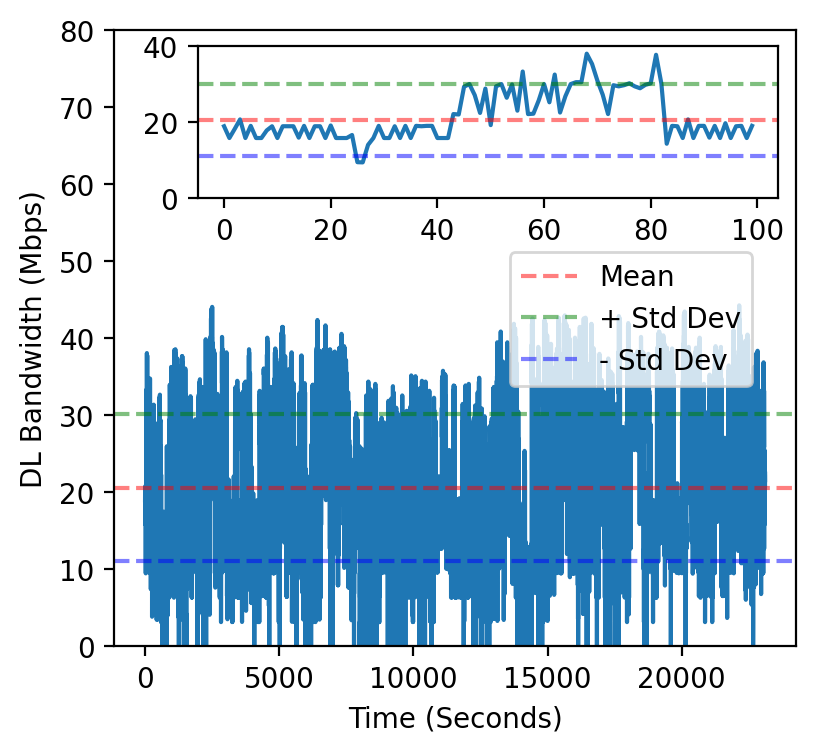

In [73]:
figure_size = (4.4, 4)
fig, ax1 = plt.subplots(figsize=figure_size, dpi=200)
ax1.set_xlabel('Time (Seconds)')
ax1.set_ylabel('DL Bandwidth (Mbps)')
ax1.set_ylim(bottom=0, top=80)

left, bottom, width, height = [0.22, 0.67, 0.66, 0.19]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_ylim(bottom=0, top=40)

ax1.plot(df['bandwidth'])

alpha_val = 0.5
# Plot mean and standard deviation lines on ax1
ax1.axhline(mean_value, color='r', linestyle='--', alpha=alpha_val, label='Mean')
ax1.axhline(mean_value + std_value, color='g', linestyle='--', alpha=alpha_val, label='+ Std Dev')
ax1.axhline(mean_value - std_value, color='b', linestyle='--', alpha=alpha_val, label='- Std Dev')

# Add legend
ax1.legend(loc='lower left', bbox_to_anchor=(0.56, 0.4))

ax2.plot(df['bandwidth'][:100])
# Plot mean and standard deviation lines on ax2
ax2.axhline(mean_value, color='r', linestyle='--', alpha=alpha_val, label='Mean')
ax2.axhline(mean_value + std_value, color='g', linestyle='--', alpha=alpha_val, label='+ Std Dev')
ax2.axhline(mean_value - std_value, color='b', linestyle='--', alpha=alpha_val, label='- Std Dev')
fig.savefig(f'plots/NYU-METS-data.pdf', bbox_inches='tight')

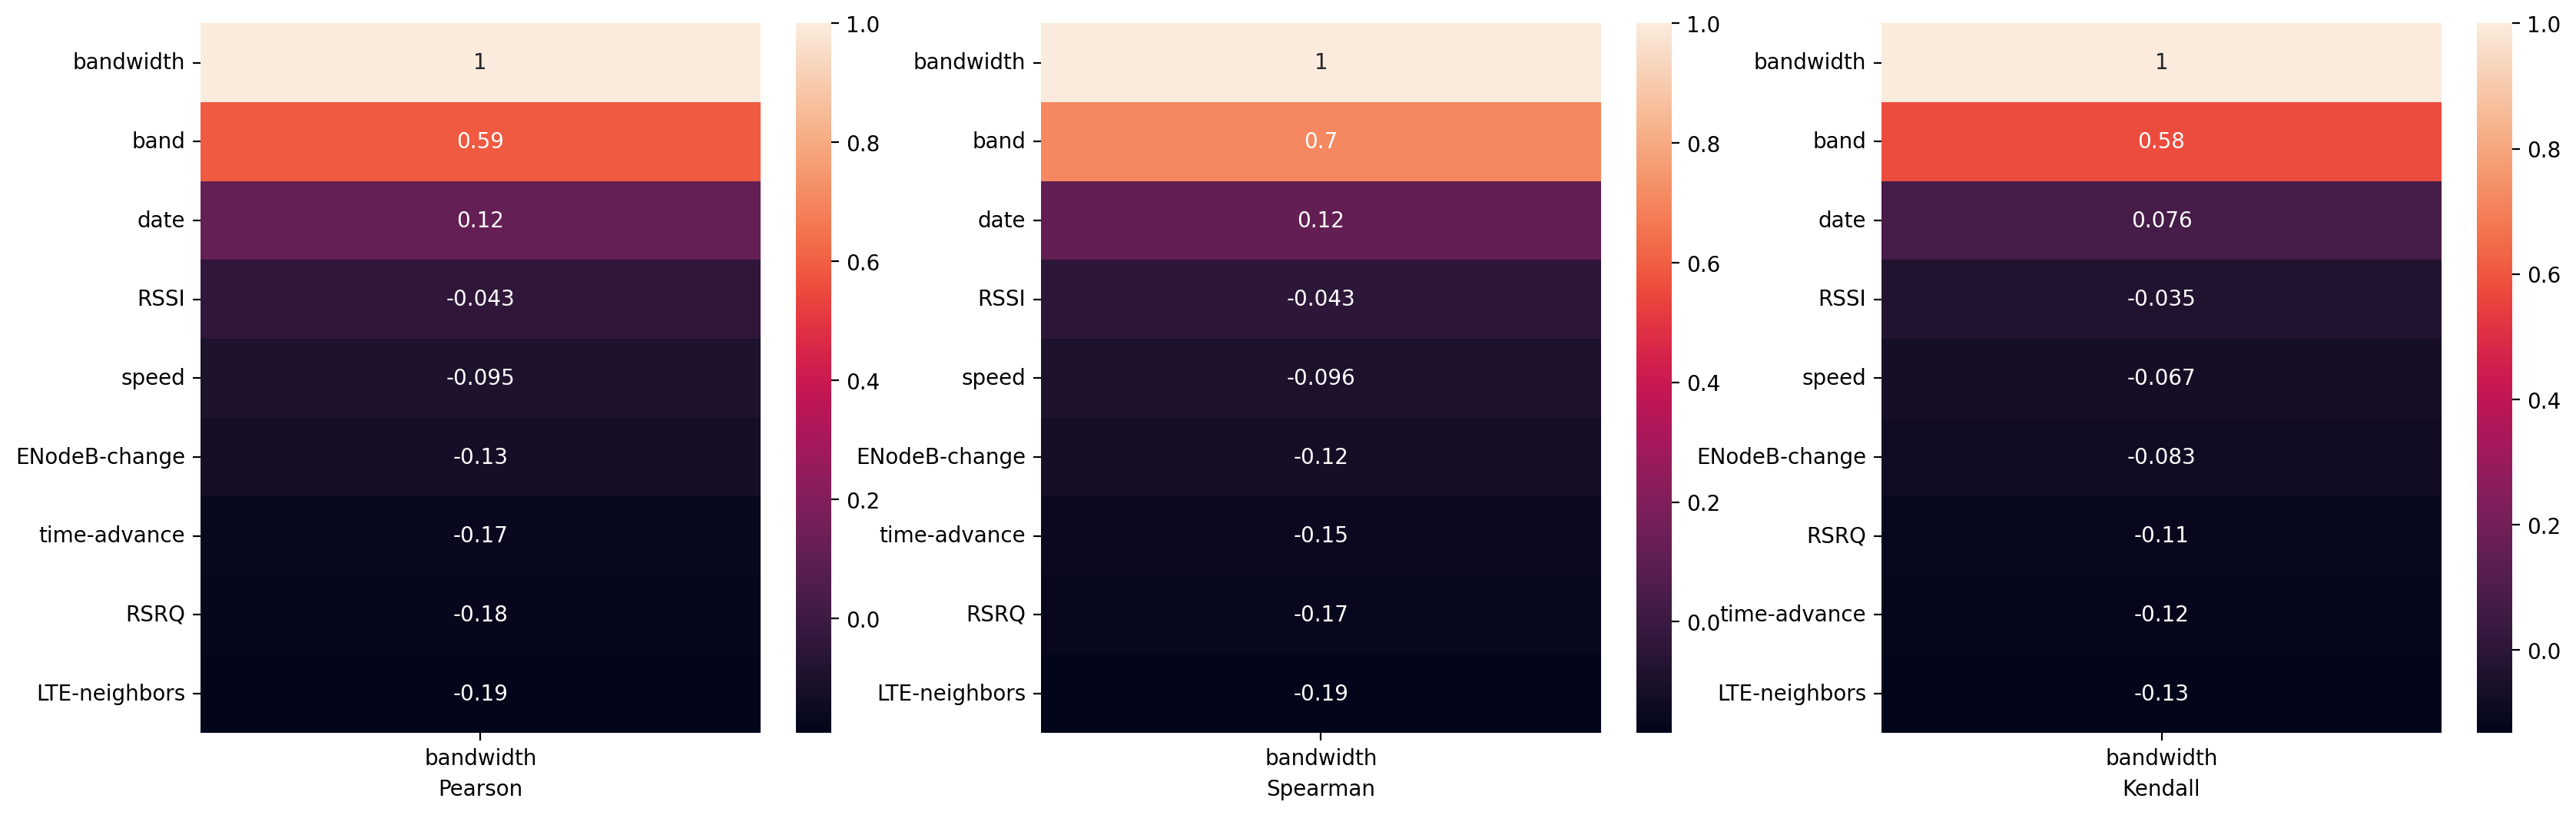

In [51]:
pearson, spearman, kendall = correlation.multi(df, 'bandwidth')

In [52]:
df_corr = pearson
df_corr['pearson'] = pearson
df_corr['spearman'] = spearman
df_corr['kendall'] = kendall
df_corr.drop(columns=['bandwidth'], inplace=True)

df_corr['average'] = df_corr.mean(axis=1)
df_corr

,pearson,spearman,kendall,average
bandwidth,1.000000,1.000000,1.000000,1.000000
band,0.588150,0.703766,0.578553,0.623490
date,0.117147,0.116260,0.076173,0.103193
RSSI,-0.043194,-0.042751,-0.035101,-0.040349
speed,-0.094960,-0.095904,-0.067285,-0.086050
ENodeB-change,-0.126311,-0.119664,-0.083394,-0.109790
time-advance,-0.168848,-0.153431,-0.121861,-0.148047
RSRQ,-0.177710,-0.166301,-0.113868,-0.152626
LTE-neighbors,-0.192292,-0.186317,-0.132571,-0.170393


In [ ]:
len(df) * 0.2
scope = 4621

In [ ]:
df.tail(scope)['bandwidth'].head()

In [ ]:
#bandwidth_tail = df.tail(scope*2).head(scope)['bandwidth'].to_numpy()
tail = df.tail(scope)
type(tail)

In [ ]:
tail = tail[['bandwidth']]
type(tail)

In [ ]:
tail.head()

In [ ]:
#test_data = np.arange(50)
#tail = pd.DataFrame({'bandwidth': test_data})
#tail.head()

In [ ]:
span = 8
pred_len = 48

truth = []
ewma8 = []
shifted = []

tail['EWMA8'] = tail['bandwidth'].ewm(span=span, min_periods=8, adjust=True).mean()

b_truth  = tail['bandwidth'].to_numpy()
b_ewma8 = tail['EWMA8'].to_numpy()
#tail.head(30)

In [ ]:
#b_truth[(span):(span+pred_len)]

In [ ]:
#b_ewma8[0+span-1]

In [ ]:
#b_truth[0+span-1]

In [ ]:
for i in range(len(b_truth) - span - pred_len):
    truth.append(b_truth[(i+span):(i+span+pred_len)])
    ewma8.append(np.repeat(b_ewma8[i+span-1], pred_len)) #correct?
    #ewma8.append(np.repeat(b_ewma8[i+span-0], pred_len)) #informer
    shifted.append(np.repeat(b_truth[i+span-1], pred_len))

#EWMA
rmse = root_mean_squared_error(truth, ewma8)
mae = mean_absolute_error(truth, ewma8)
print(f'EWMA8 rmse: {rmse}, mae: {mae}')

#Shifted
rmse = root_mean_squared_error(truth, shifted)
mae = mean_absolute_error(truth, shifted)
print(f'Shifted rmse: {rmse}, mae: {mae}')

In [ ]:
df.info()

In [ ]:
scope = 4621 + 32
tail_arima = df.tail(scope).tail(scope)
tail_arima = tail_arima[['bandwidth']]

In [ ]:
# ARIMA model parameters (p, d, q)
p = 1  # AutoRegressive (AR) order
d = 1  # Differencing (I) order
q = 0  # Moving Average (MA) order

# Function to predict next value using ARIMA model
def predict_next_value(data, window_size=32, horizon=1):
    predictions = []
    for i in range(len(data) - window_size):
        window = data.iloc[i:i+window_size]  # Accessing by index using iloc
        model = ARIMA(window, order=(p, d, q))  # Example ARIMA model, you may need to adjust the parameters
        model_fit = model.fit()
        next_value = model_fit.forecast(steps=horizon)  # Extracting the forecasted value
        #print(type(next_value.values))
        #print((next_value.values))
        #print((next_value.iloc[0]))
        predictions.append(next_value.values)
        #predictions.append(next_value.iloc[0])
    return predictions

# Define the rolling window size and prediction horizon
window_size = 32
prediction_horizon = 3

# Predict the next value using ARIMA model with a rolling window
predictions = predict_next_value(tail_arima['bandwidth'], window_size=window_size, horizon=prediction_horizon)

In [ ]:
print(f'len(predictions): {len(predictions)}')
print(f'len(predictions[0]): {len(predictions[0])}')
#print(f'predictions[0]: {(predictions[0])}')

# Evaluate the predictions
actual_values = tail_arima['bandwidth']
#actual_values = tail_arima['datarate'].iloc[window_size:]
print(f'len(actual_values): {len(actual_values)}')

arima_labels = []
for i in range(len(actual_values) - window_size - prediction_horizon + 1):
    #print(i)
    arima_labels.append(actual_values[(i+window_size):(i+window_size+prediction_horizon)])

print(f'len(arima_labels): {len(arima_labels)}')
#print(f'len(arima_labels): {len(arima_labels[0])}')

#selected_arima_labels = arima_labels[-(len(predictions)):]
#print(f'len(selected_arima_labels): {len(selected_arima_labels)}')
#print(f'len(selected_arima_labels): {len(selected_arima_labels[0])}')

selected_predictions = predictions[:len(arima_labels)]
print(f'len(selected_predictions): {len(selected_predictions)}')

#ARIMA
rmse = root_mean_squared_error(arima_labels, selected_predictions)
mae = mean_absolute_error(arima_labels, selected_predictions)
print(f'ARIMA rmse: {rmse}, mae: {mae}')